In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [5]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import csim as cs

In [6]:
from functools import partial

In [ ]:
!python 

In [14]:
import qutip

In [15]:
import plotly.express as px

In [16]:
import pandas as pd

In [17]:
u = cs.random_unitary_gate(2)
m = cs.transfer_matrix(u)

In [40]:
m_choi = cs.matrix_to_choi(u)

In [ ]:
qutip.

In [41]:
m_choi

array([[ 0.58530817-7.28887457e-18j, -0.21678991-4.15168646e-01j,
         0.14981956+1.21961215e-01j,  0.0947596 +3.52463287e-01j],
       [-0.21678991+4.15168646e-01j,  0.41469183-4.98984317e-19j,
        -0.22026568+4.06739572e-02j, -0.14981956-1.21961215e-01j],
       [ 0.14981956-1.21961215e-01j, -0.22026568-4.06739572e-02j,
         0.22769554+1.30959756e-19j, -0.13760305+2.54675648e-01j],
       [ 0.0947596 -3.52463287e-01j, -0.14981956+1.21961215e-01j,
        -0.13760305-2.54675648e-01j,  0.77230446-7.45351398e-18j]])

In [44]:
tot_qo = cs.np_to_kraus(m_choi)

for qo in tot_qo:
    display(np.linalg.norm(qo))
    

# only two relevant

1.1737259170741312

1.4163829993394987e-08

0.7889027009641237

6.1193011642208205e-09

In [199]:
# Correct value
sum([m.data.T.conjugate() @ m.data for m in tot_qo]).toarray()

array([[1.00000000e+00+0.00000000e+00j, 1.82040312e-16-3.10304303e-16j],
       [1.82040312e-16+3.10304303e-16j, 1.00000000e+00+0.00000000e+00j]])

In [200]:
kraus_mats = [m.data.toarray() for m in tot_qo[:2]]

In [201]:
for i, km in enumerate(kraus_mats):
    evals = np.linalg.eigvals(km)
    print(i)
    print(np.linalg.norm(km))
    print(evals)
    ratio = min(np.abs(evals[0]) / np.abs(evals[1]), np.abs(evals[1]) / np.abs(evals[0]))
    print(ratio)

0
1.3411785334471595
[0.87387703+0.32578547j 0.26372832-0.92554612j]
0.9690794300074022
1
0.4485979730454944
[ 0.16783577-0.16648205j -0.34428735+0.06156899j]
0.6759138266172304


In [58]:
ratios = []
num_good_mat = np.zeros(4)

In [59]:

for _ in tqdm(range(1000)):
    u = cs.random_unitary_gate(2)
    m_choi = cs.matrix_to_choi(u)
    k_ops = cs.np_to_kraus(qutip.Qobj(m_choi))

    count = 0
    
    for km in k_ops:
        if (np.linalg.norm(km) < 1e-3):
            # disregard
            continue
        count += 1
        evals = np.linalg.eigvals(km)
        ratio = np.abs(evals[0]) / np.abs(evals[1])
        ratios.append(ratio)
    num_good_mat[count] += 1
    

In [60]:
num_good_mat

array([   0.,    0., 1000.,    0.])

In [61]:
ratios = np.array(ratios)

In [62]:
ratios.shape

(2000,)

In [63]:
px.histogram(pd.DataFrame({'ratios': ratios}), x = 'ratios', nbins = 100)

In [64]:
px.histogram(pd.DataFrame({'ratios': np.min([1/ratios, ratios],axis=0)}), x = 'ratios', nbins = 100)

In [65]:
px.histogram(pd.DataFrame({'ratios': np.min([1/ratios, ratios],axis=0)}), x = 'ratios', nbins = 100, histnorm='probability density')

In [66]:
px.histogram(pd.DataFrame({'ratios': np.exp(np.min([1/ratios, ratios],axis=0))}), x = 'ratios', nbins = 100)

In [295]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
#     DISTRIBUTIONS = [st.loggamma]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tqdm(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                print(distribution)
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                print(sse)
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000, x = None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    if x is None:
        x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [296]:
df = pd.DataFrame({'ratios': np.min([1/ratios, ratios],axis=0)}); data = df['ratios']
df

,ratios
0,0.808005
1,0.886688
2,0.998767
3,0.680163
4,0.843290
...,...
19995,0.807224
19996,0.889708
19997,0.755379
19998,0.774625


<Figure size 864x576 with 0 Axes>

/Users/diego/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



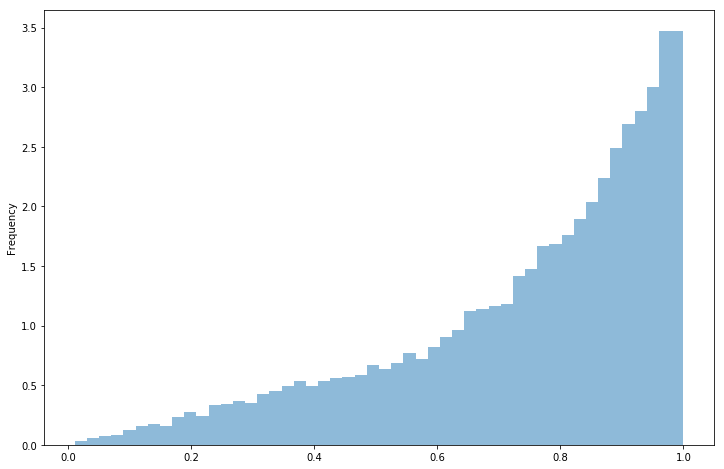

In [297]:
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

136.82651986483927
162.08221285040162
130.54991328677346
61.187074921784124
131.87563727015896
184.62228191717793
27.000307205191092
96.32971422681265
125.53336186059417
132.11395666957193
386.74374900688366
100.56520320195966
118.80768128496996
132.62282504701318
300.61961331239024
123.13633050583697
48.19804412863623
57.240317230224164
123.70283821729561
123.58551932522445
112.30229518221441
92.15704666373082
123.10735132695625
78.54189302245715
19.37174495058543
18.673867592994416
85.8266108276633
140.64697474377354
187.28647821880284
19.371522709392885
82.00791084969394
130.81638520888603
36.15748678346574
44.780641880617814
258.7439856638221
79.09807664594784
167.5770484858229
78.44632701987318
285.9897185398439
267.06425963606506
261.39880575664927
181.83554247819956
106.57846118942106
132.84101260496
141.35388967737182
167.56854385074544
19.29436839222018
35.63206099966114
181.8369528614869
178.64065840719405
104.11813055419982
112.31100825422696
18.270569166252884
104.473463073

(0.0, 3.6475598150146733)

Text(0.5, 1.0, 'T')

Text(0.5, 3.200000000000003, 'X')

Text(17.200000000000003, 0.5, 'Y')

/Users/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4740: RuntimeWarning:

divide by zero encountered in log

/Users/diego/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:136: RuntimeWarning:

invalid value encountered in double_scalars

/Users/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning:

invalid value encountered in greater_equal

/Users/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning:

invalid value encountered in less_equal



<Figure size 864x576 with 0 Axes>

/Users/diego/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 1.0, 'T \nloggamma(c=0.00, loc=1.00, scale=0.00)')

Text(0.5, 0, 'X')

Text(0, 0.5, 'Y')

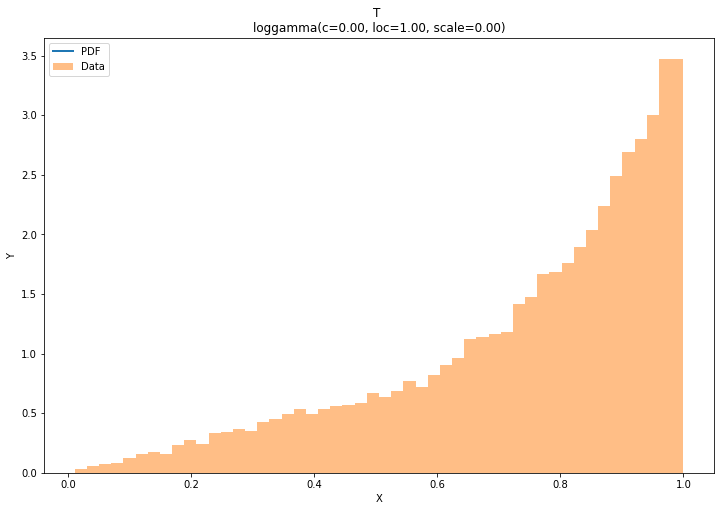

In [279]:
best_fit_name, best_fit_params = best_fit_distribution(data.iloc[:2000], 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'T')
ax.set_xlabel(u'X')
ax.set_ylabel('Y')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'T \n' + dist_str)
ax.set_xlabel(u'X')
ax.set_ylabel('Y')


18.270569166252884



(0.0, 3.6475598150146733)

Text(0.5, 1.0, 'T')

Text(0.5, 17.200000000000003, 'X')

Text(17.200000000000003, 0.5, 'Y')

/Users/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4740: RuntimeWarning:

divide by zero encountered in log

/Users/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4734: RuntimeWarning:

overflow encountered in exp



<Figure size 864x576 with 0 Axes>

/Users/diego/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 1.0, 'T \nloggamma(c=0.00, loc=1.00, scale=0.00)')

Text(0.5, 0, 'X')

Text(0, 0.5, 'Y')

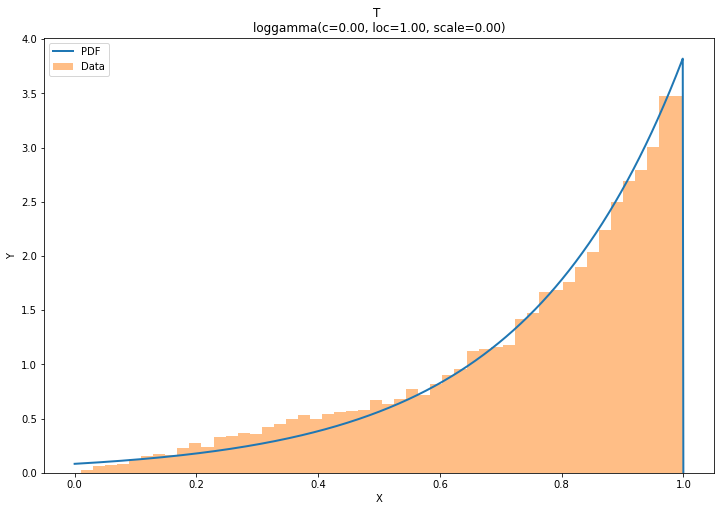

In [289]:
best_fit_name, best_fit_params = best_fit_distribution(data.iloc[:2000], 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'T')
ax.set_xlabel(u'X')
ax.set_ylabel('Y')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params, x = np.linspace(0,1,1000))

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'T \n' + dist_str)
ax.set_xlabel(u'X')
ax.set_ylabel('Y')


In [ ]:
ps = []
for x in tqdm(range(2000)):
    ps.append(cs.sample_all_qubits_faster(50, depolarizing_noise = noise_level))
ps = np.array(ps)

# April 28

In [119]:
n_qubits = 50
depolarizing_noise = None
times = None

ratios = []
ps = []
for _ in tqdm(range(1000)):
    u = cs.random_unitary_gate(2)
    
    # calculate ratios
    k_ops = cs.np_to_kraus(cs.matrix_to_choi(u))

    count = 0
    
    these_ratios = []
    for km in k_ops:
        if (np.linalg.norm(km) < 1e-3):
            # disregard
            continue
        evals = np.linalg.eigvals(km)
        ratio = np.abs(evals[0]) / np.abs(evals[1])
        ratio = np.min([1/ratio, ratio])
        these_ratios.append(ratio)
        
    ratios.append(these_ratios)
    
    ps.append(cs.sample_all_qubits_faster(50, depolarizing_noise = depolarizing_noise, times = times))
    

We will now plot distance from eigenvalues being $1$ with overlap. We will try several distances, adn we will use $-\log$ instead of overlap itself.

First, $L_2$ distance from $(1,1)$

In [120]:
min_dis = np.min(np.abs(1 - np.array(ratios)),axis=1);min_dis.shape

(1000,)

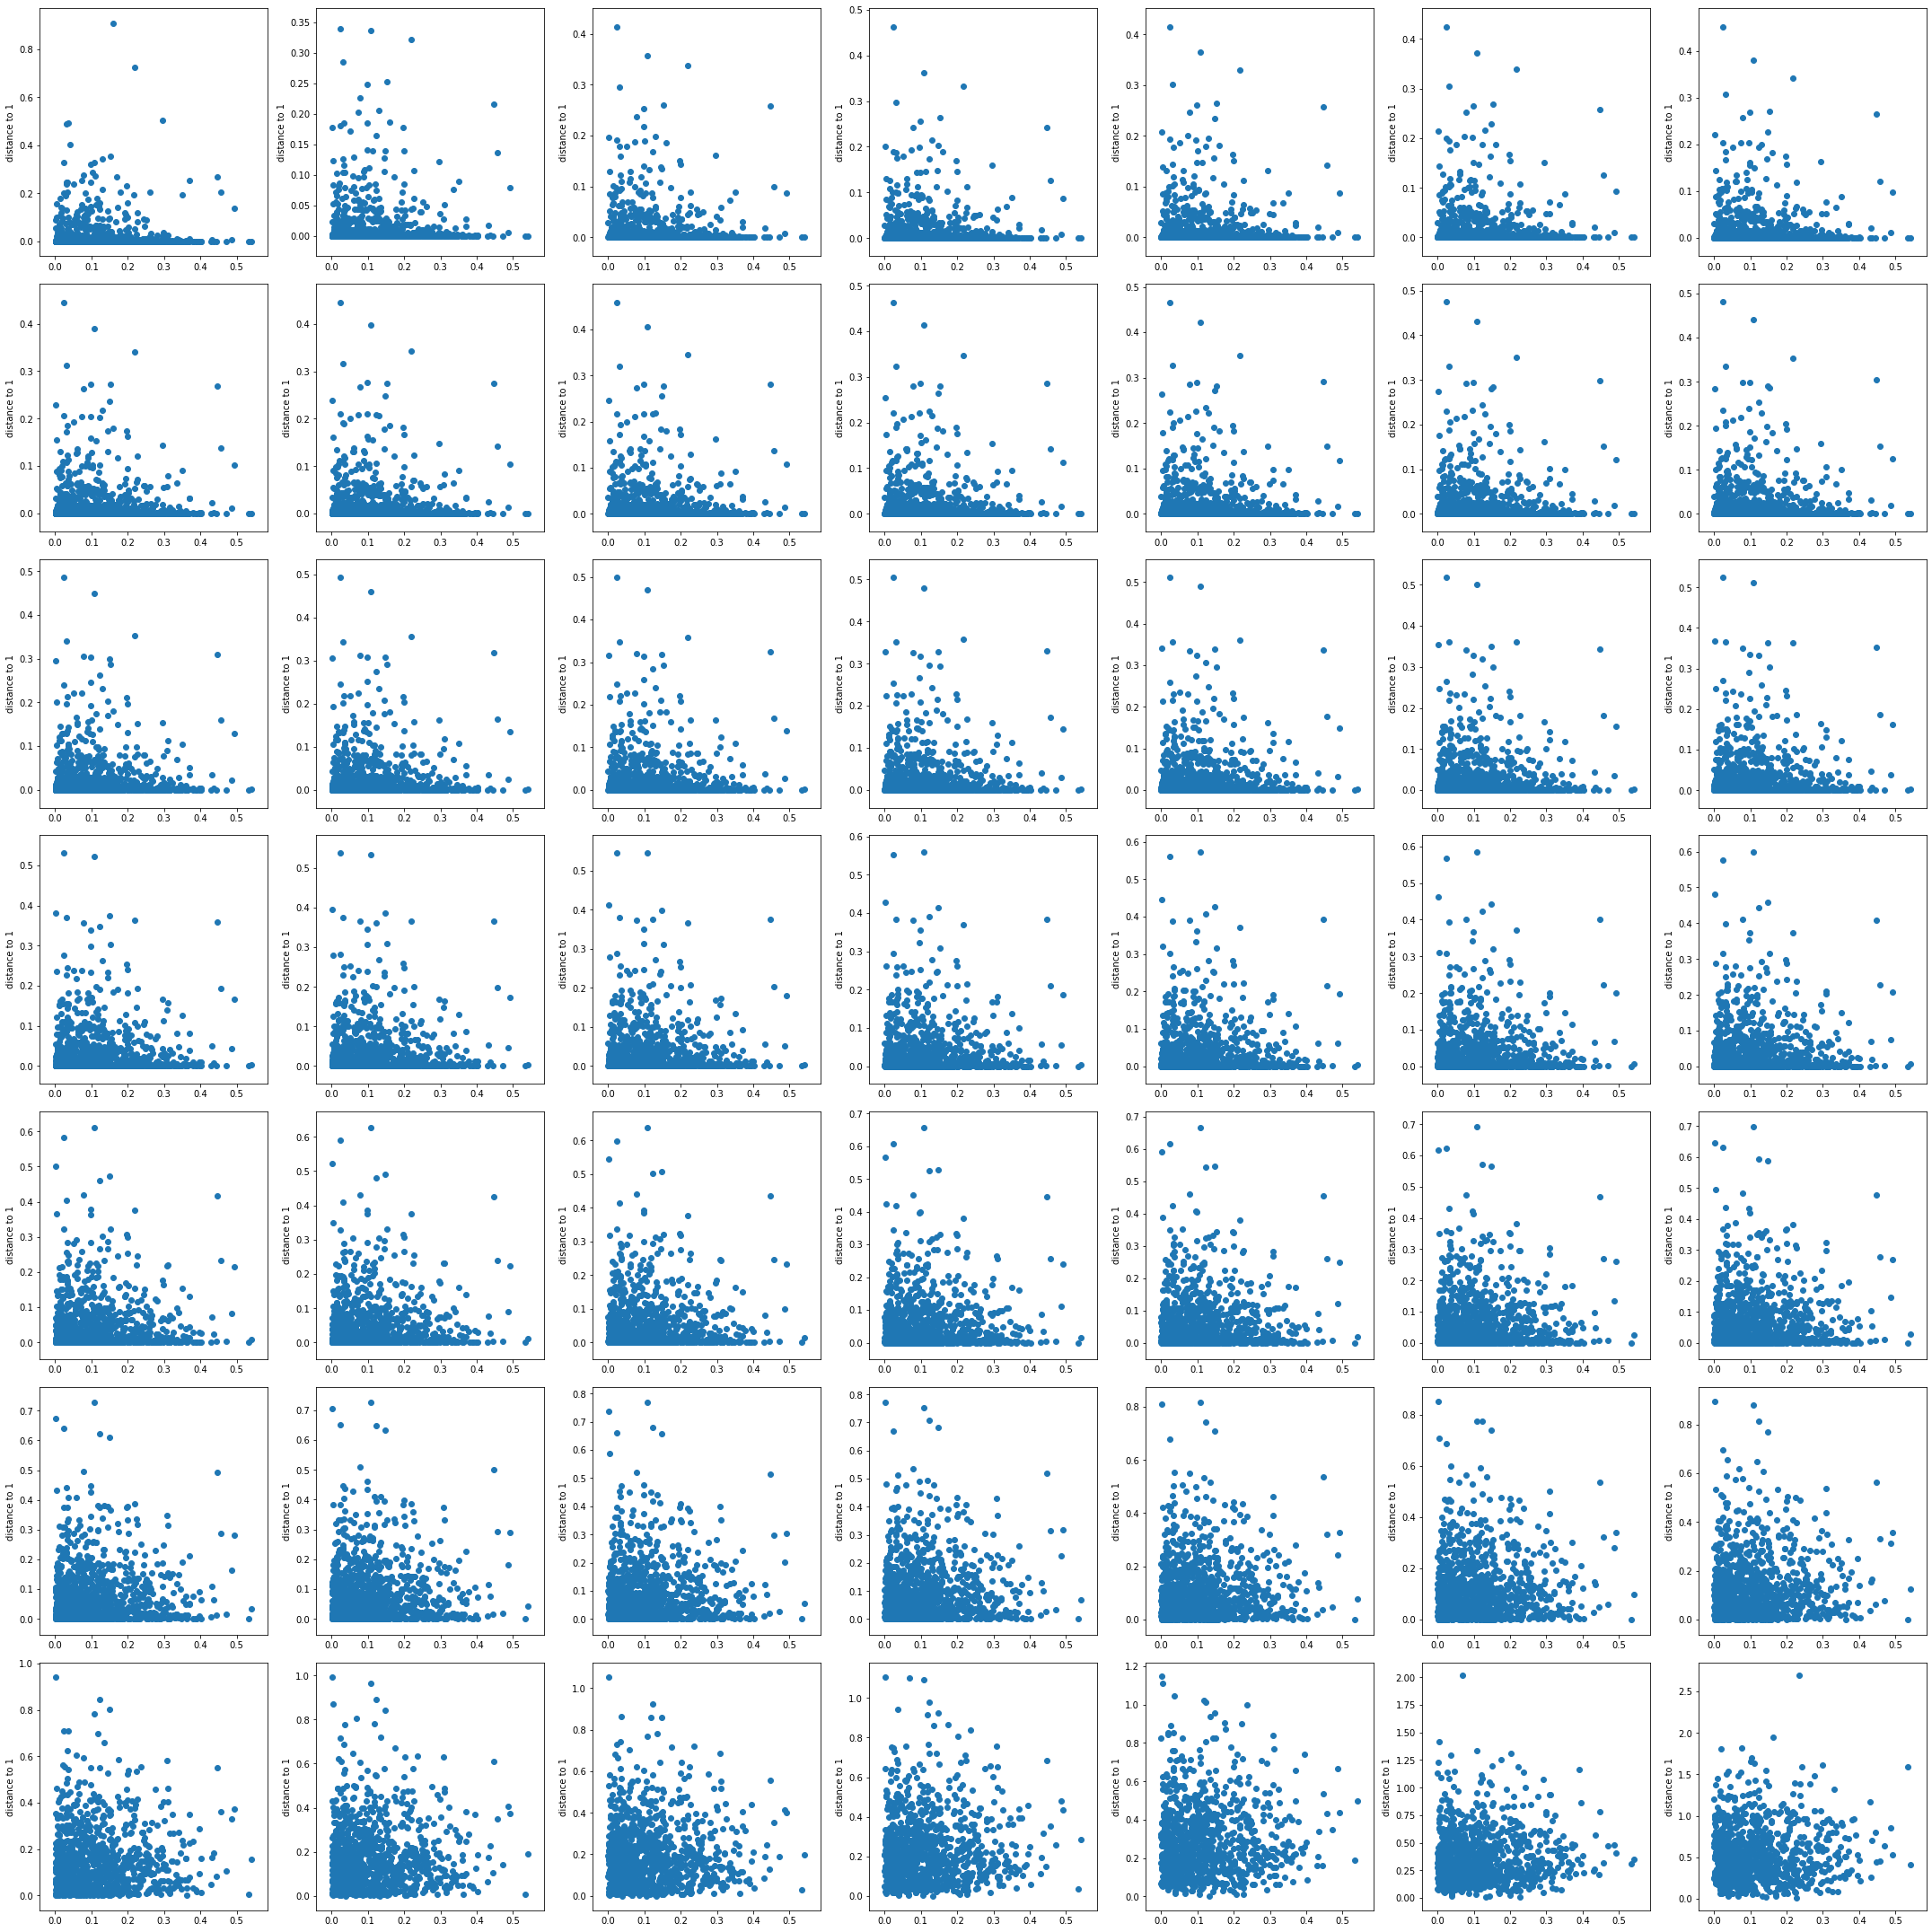

In [121]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    _=ax.scatter(min_dis, -np.log(np.array(ps)[:,i]))
    _=ax.set_ylabel(fr'\log(1/overlap)')
    _=ax.set_ylabel(fr'distance to 1')
_=fig.tight_layout()    
plt.show()

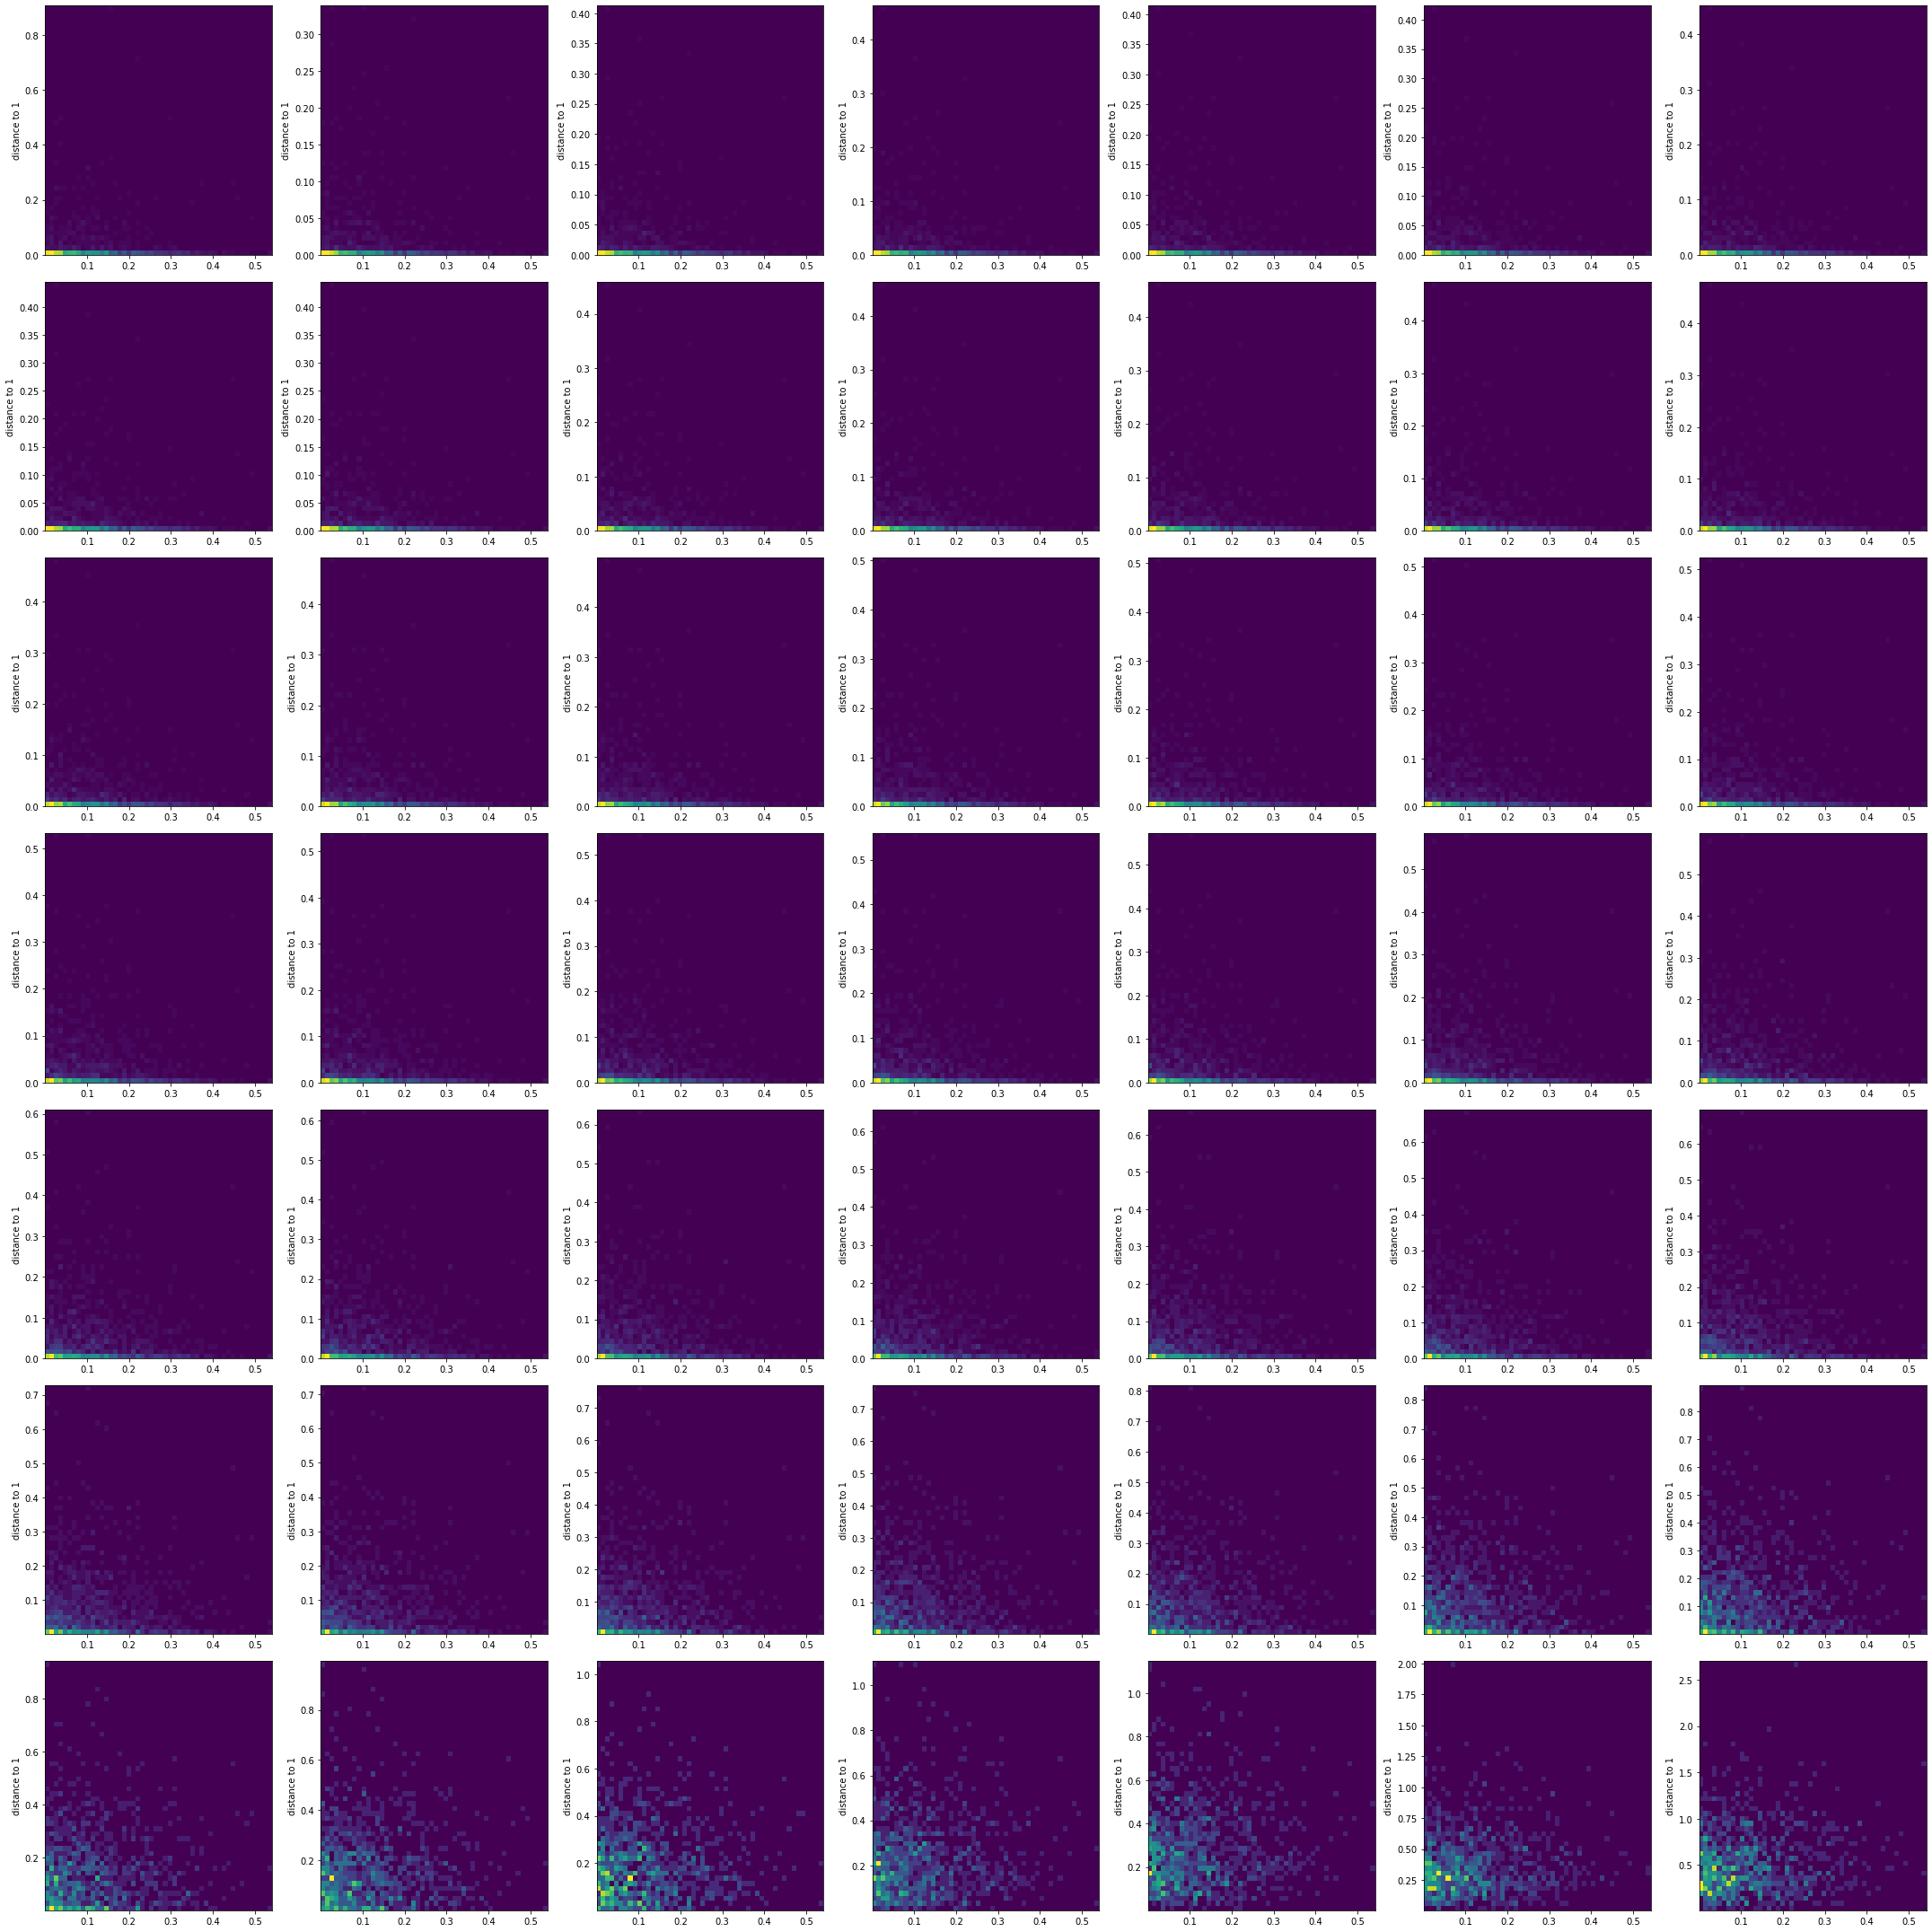

In [122]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    _=ax.hist2d(min_dis, -np.log(np.array(ps)[:,i]), bins=50)
    _=ax.set_ylabel(fr'\log(1/overlap)')
    _=ax.set_ylabel(fr'distance to 1')
_=fig.tight_layout()    
plt.show()

Second, minimum distance from $1$ from each coordinate. (I guess that's "$L_{-\infty}$")

In [123]:
min_dis = np.linalg.norm(np.abs(1 - np.array(ratios)),axis=1);min_dis.shape

(1000,)

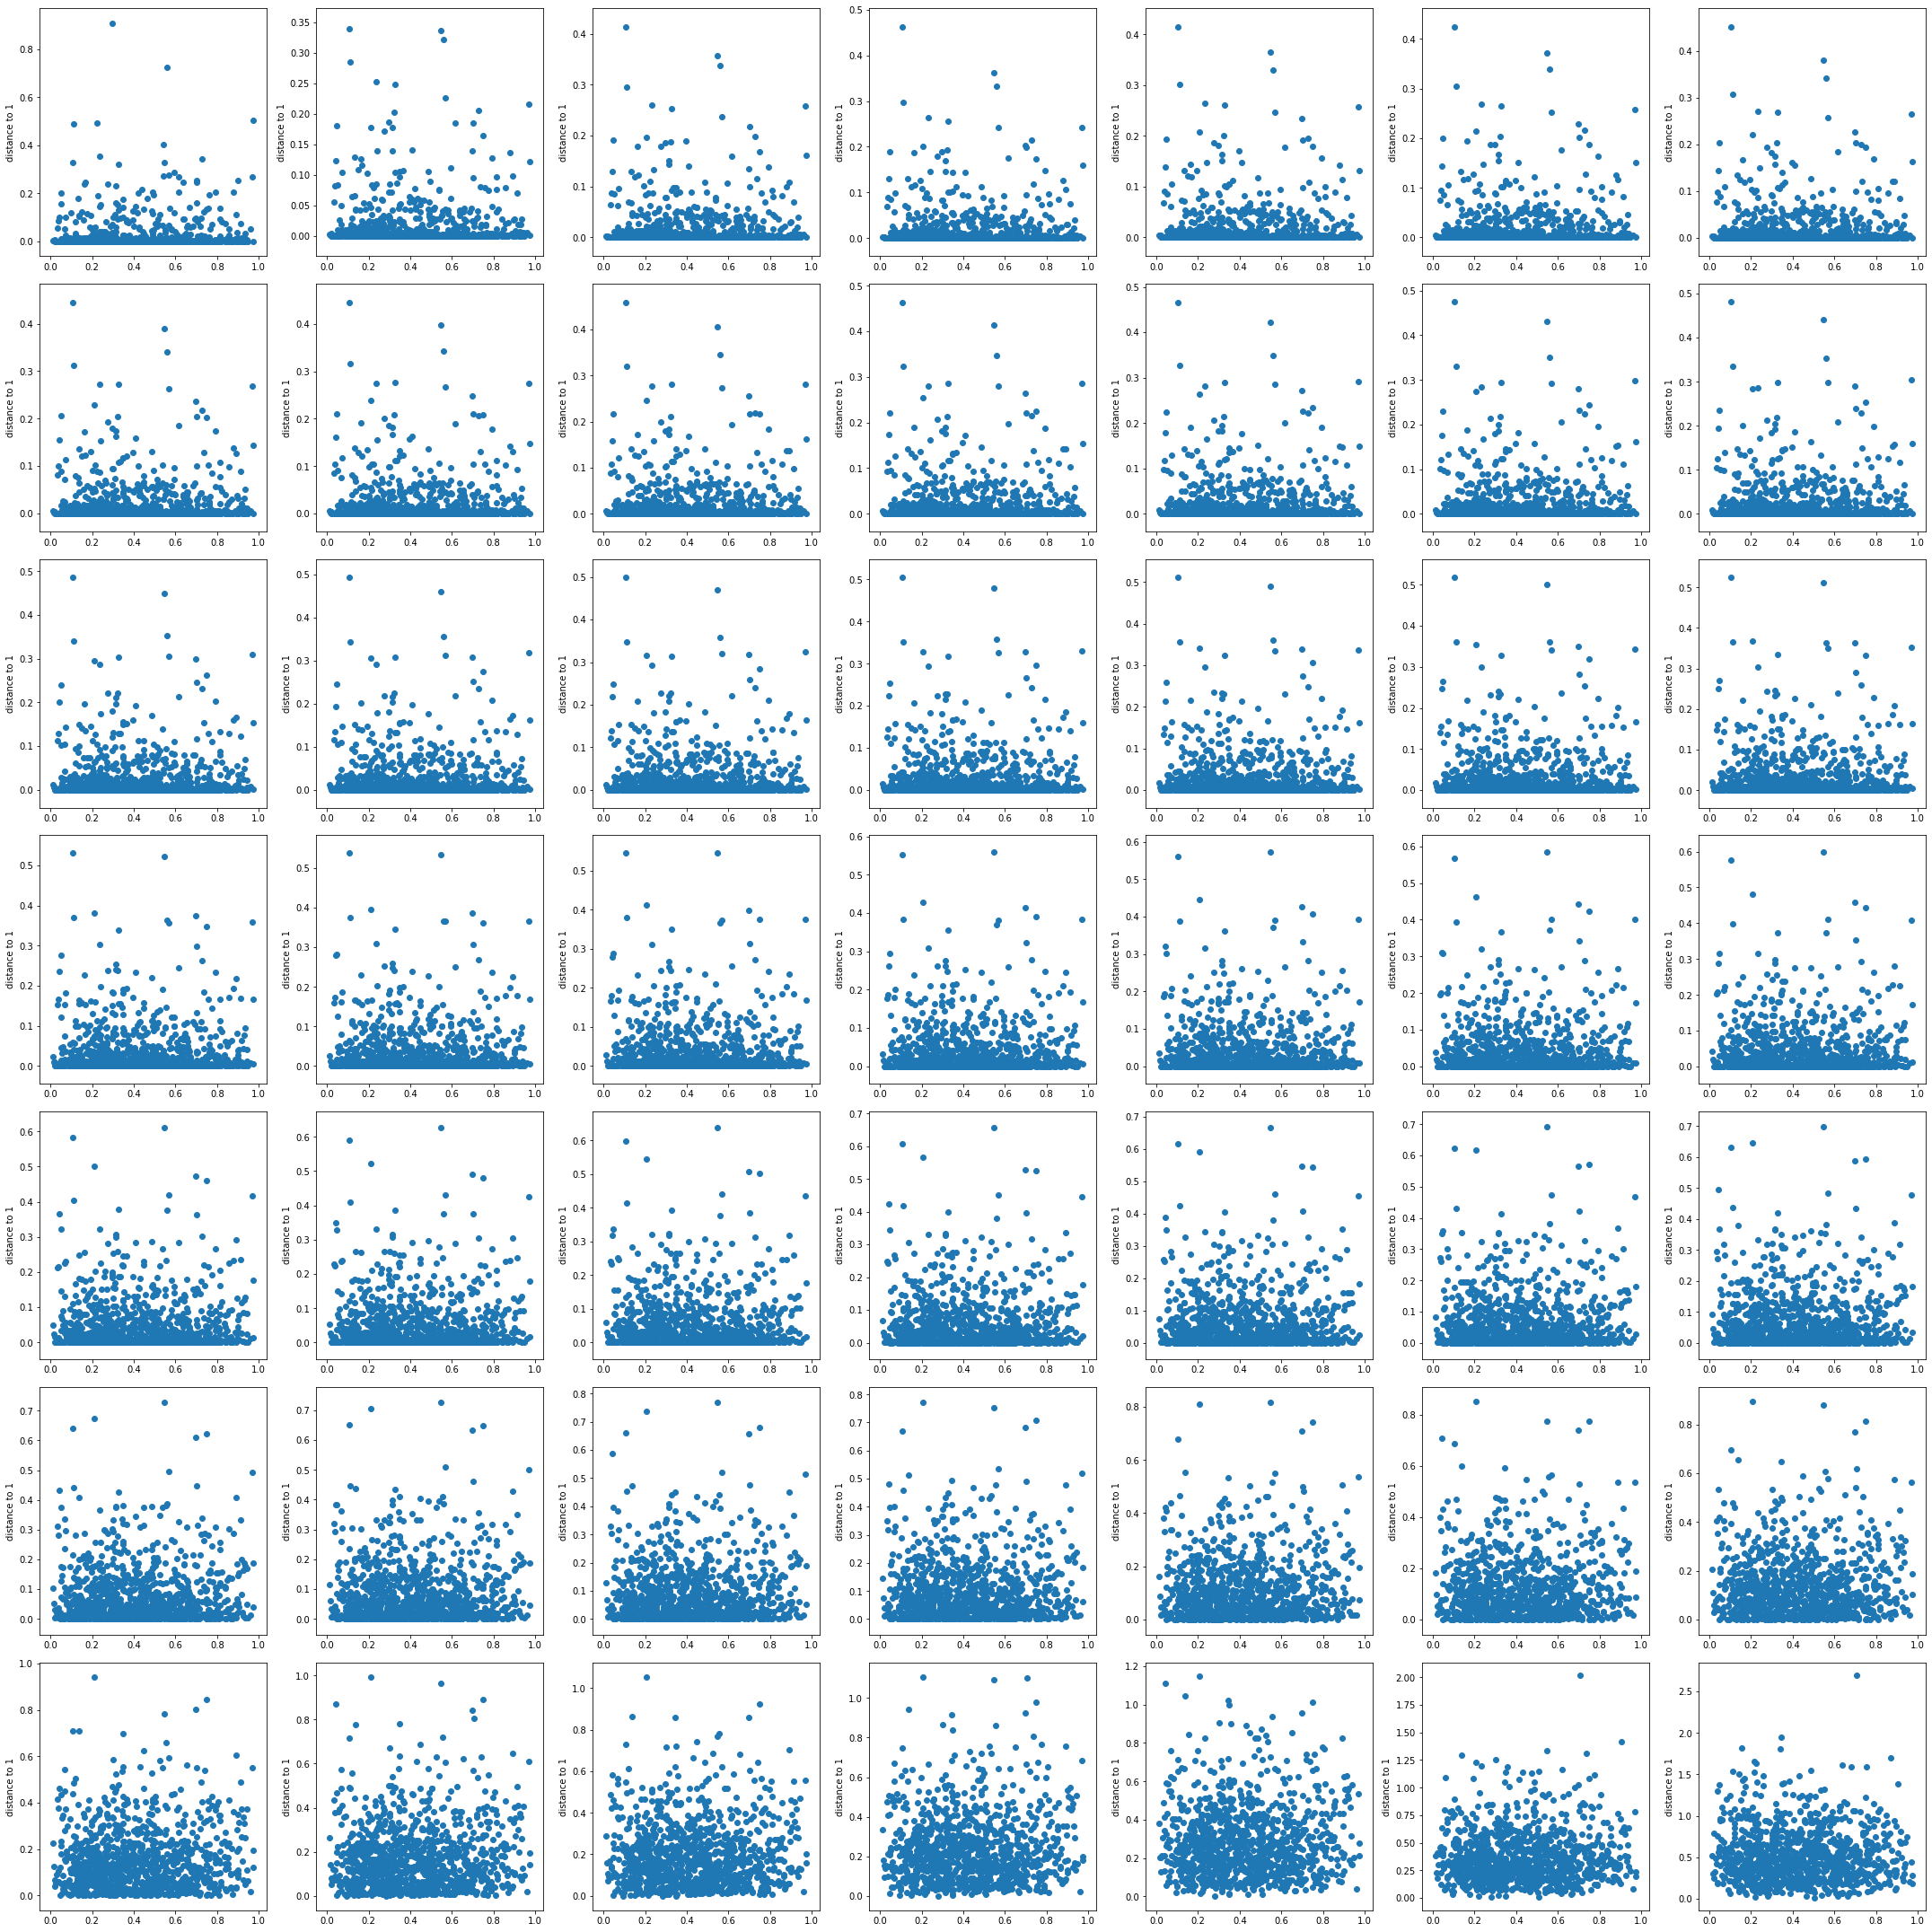

In [124]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    _=ax.scatter(min_dis, -np.log(np.array(ps)[:,i]))
    _=ax.set_ylabel(fr'\log(1/overlap)')
    _=ax.set_ylabel(fr'distance to 1')
_=fig.tight_layout()    
plt.show()

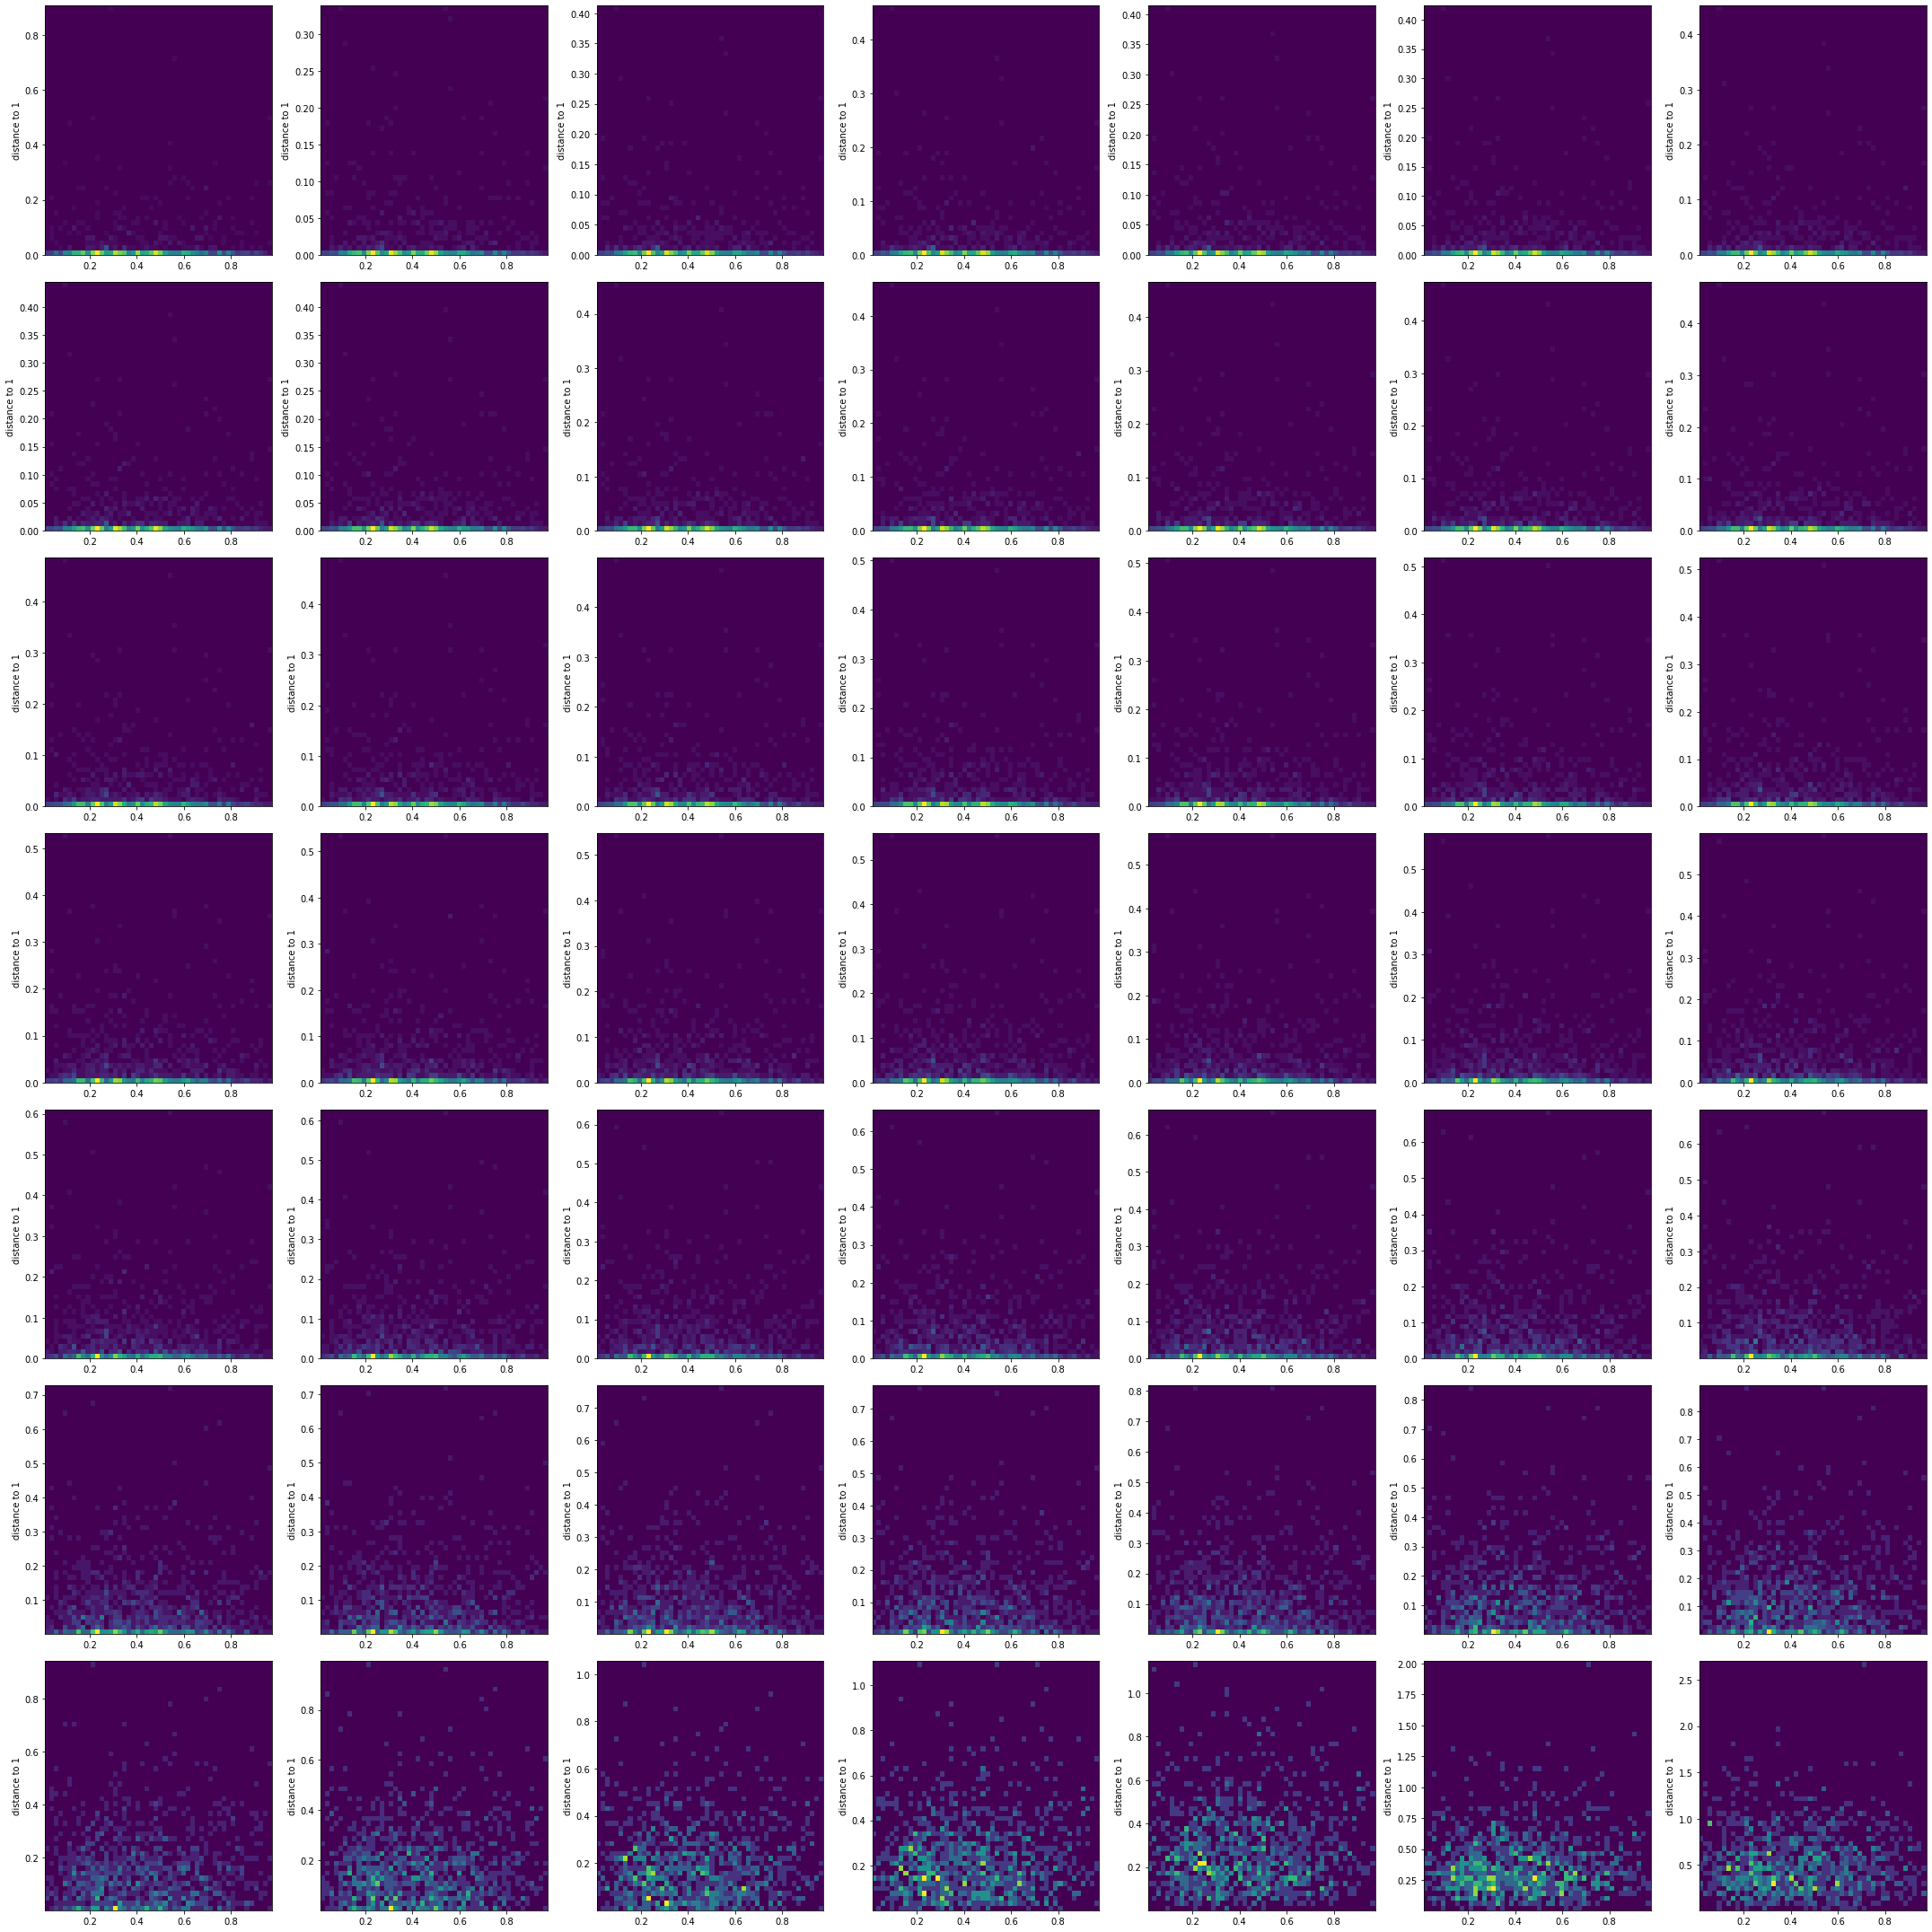

In [125]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    _=ax.hist2d(min_dis, -np.log(np.array(ps)[:,i]), bins=50)
    _=ax.set_ylabel(fr'\log(1/overlap)')
    _=ax.set_ylabel(fr'distance to 1')
_=fig.tight_layout()    
plt.show()

Third, the distance of the first one to $1$. We avoid fake left accumulation from taking the minimum, but we get some noise.

In [126]:
min_dis = np.abs(1 - np.array(ratios))[:,0];min_dis.shape

(1000,)

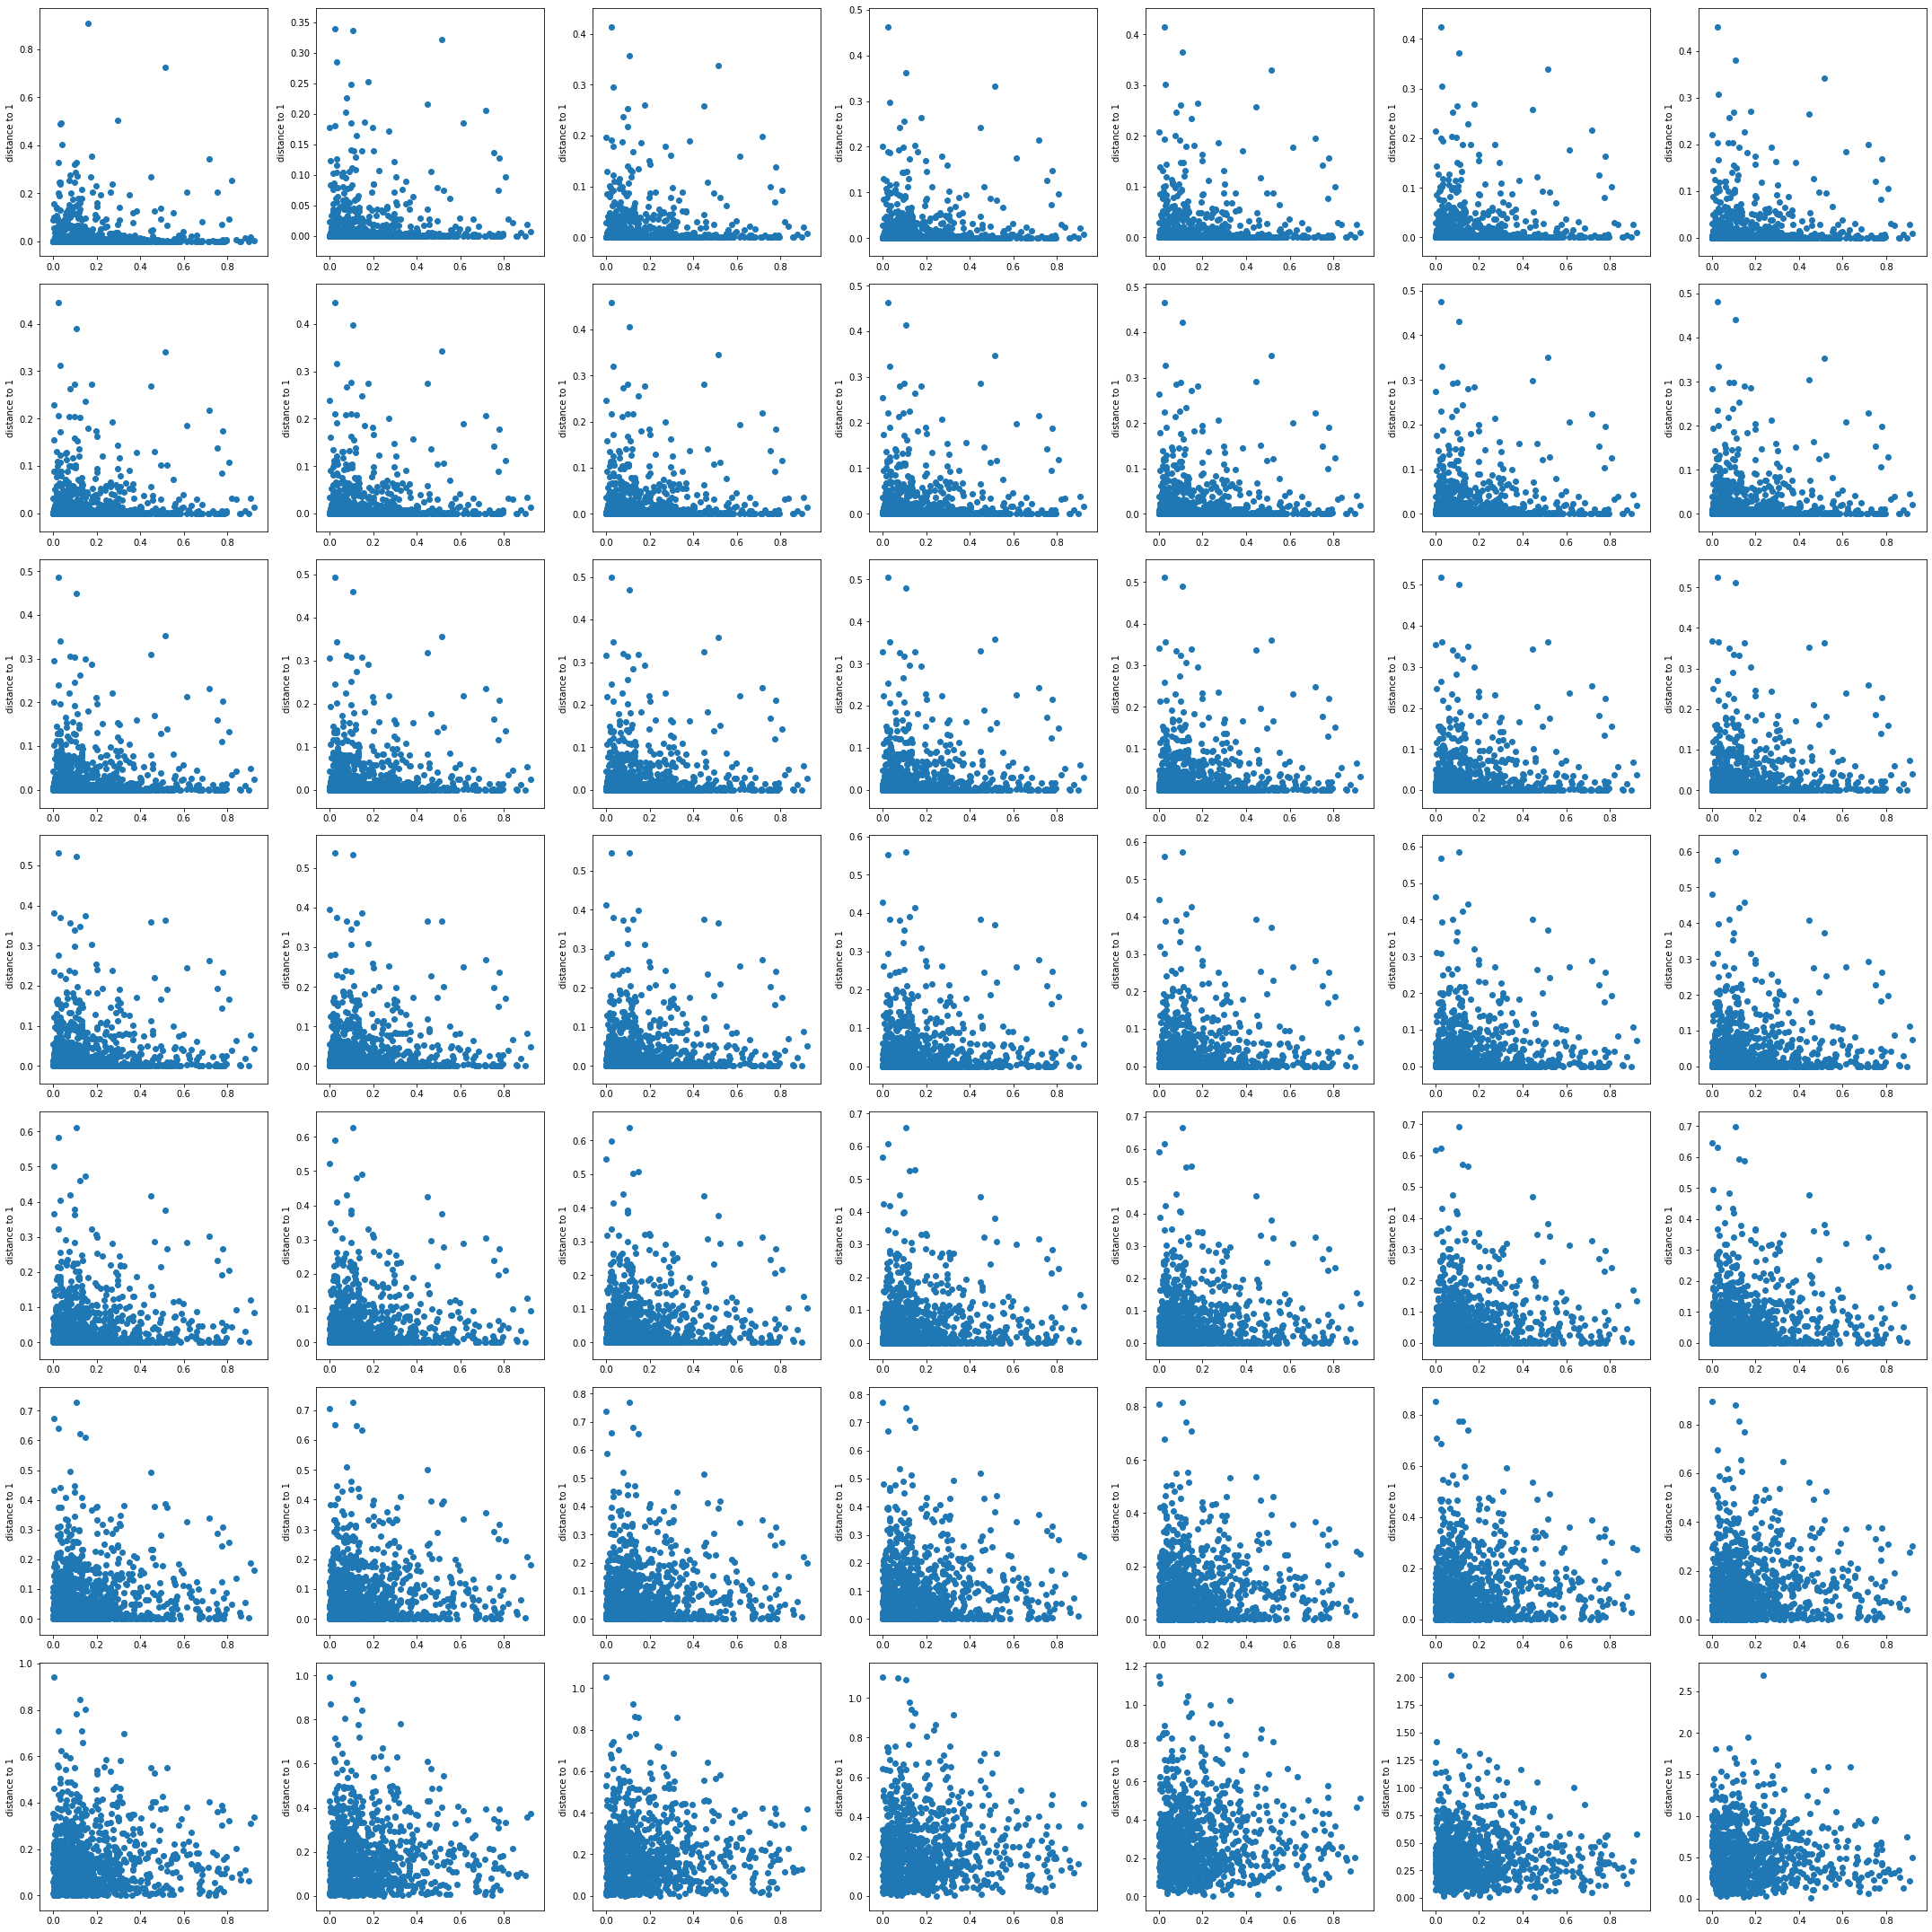

In [127]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    _=ax.scatter(min_dis, -np.log(np.array(ps)[:,i]))
    _=ax.set_ylabel(fr'\log(1/overlap)')
    _=ax.set_ylabel(fr'distance to 1')
_=fig.tight_layout()    
plt.show()

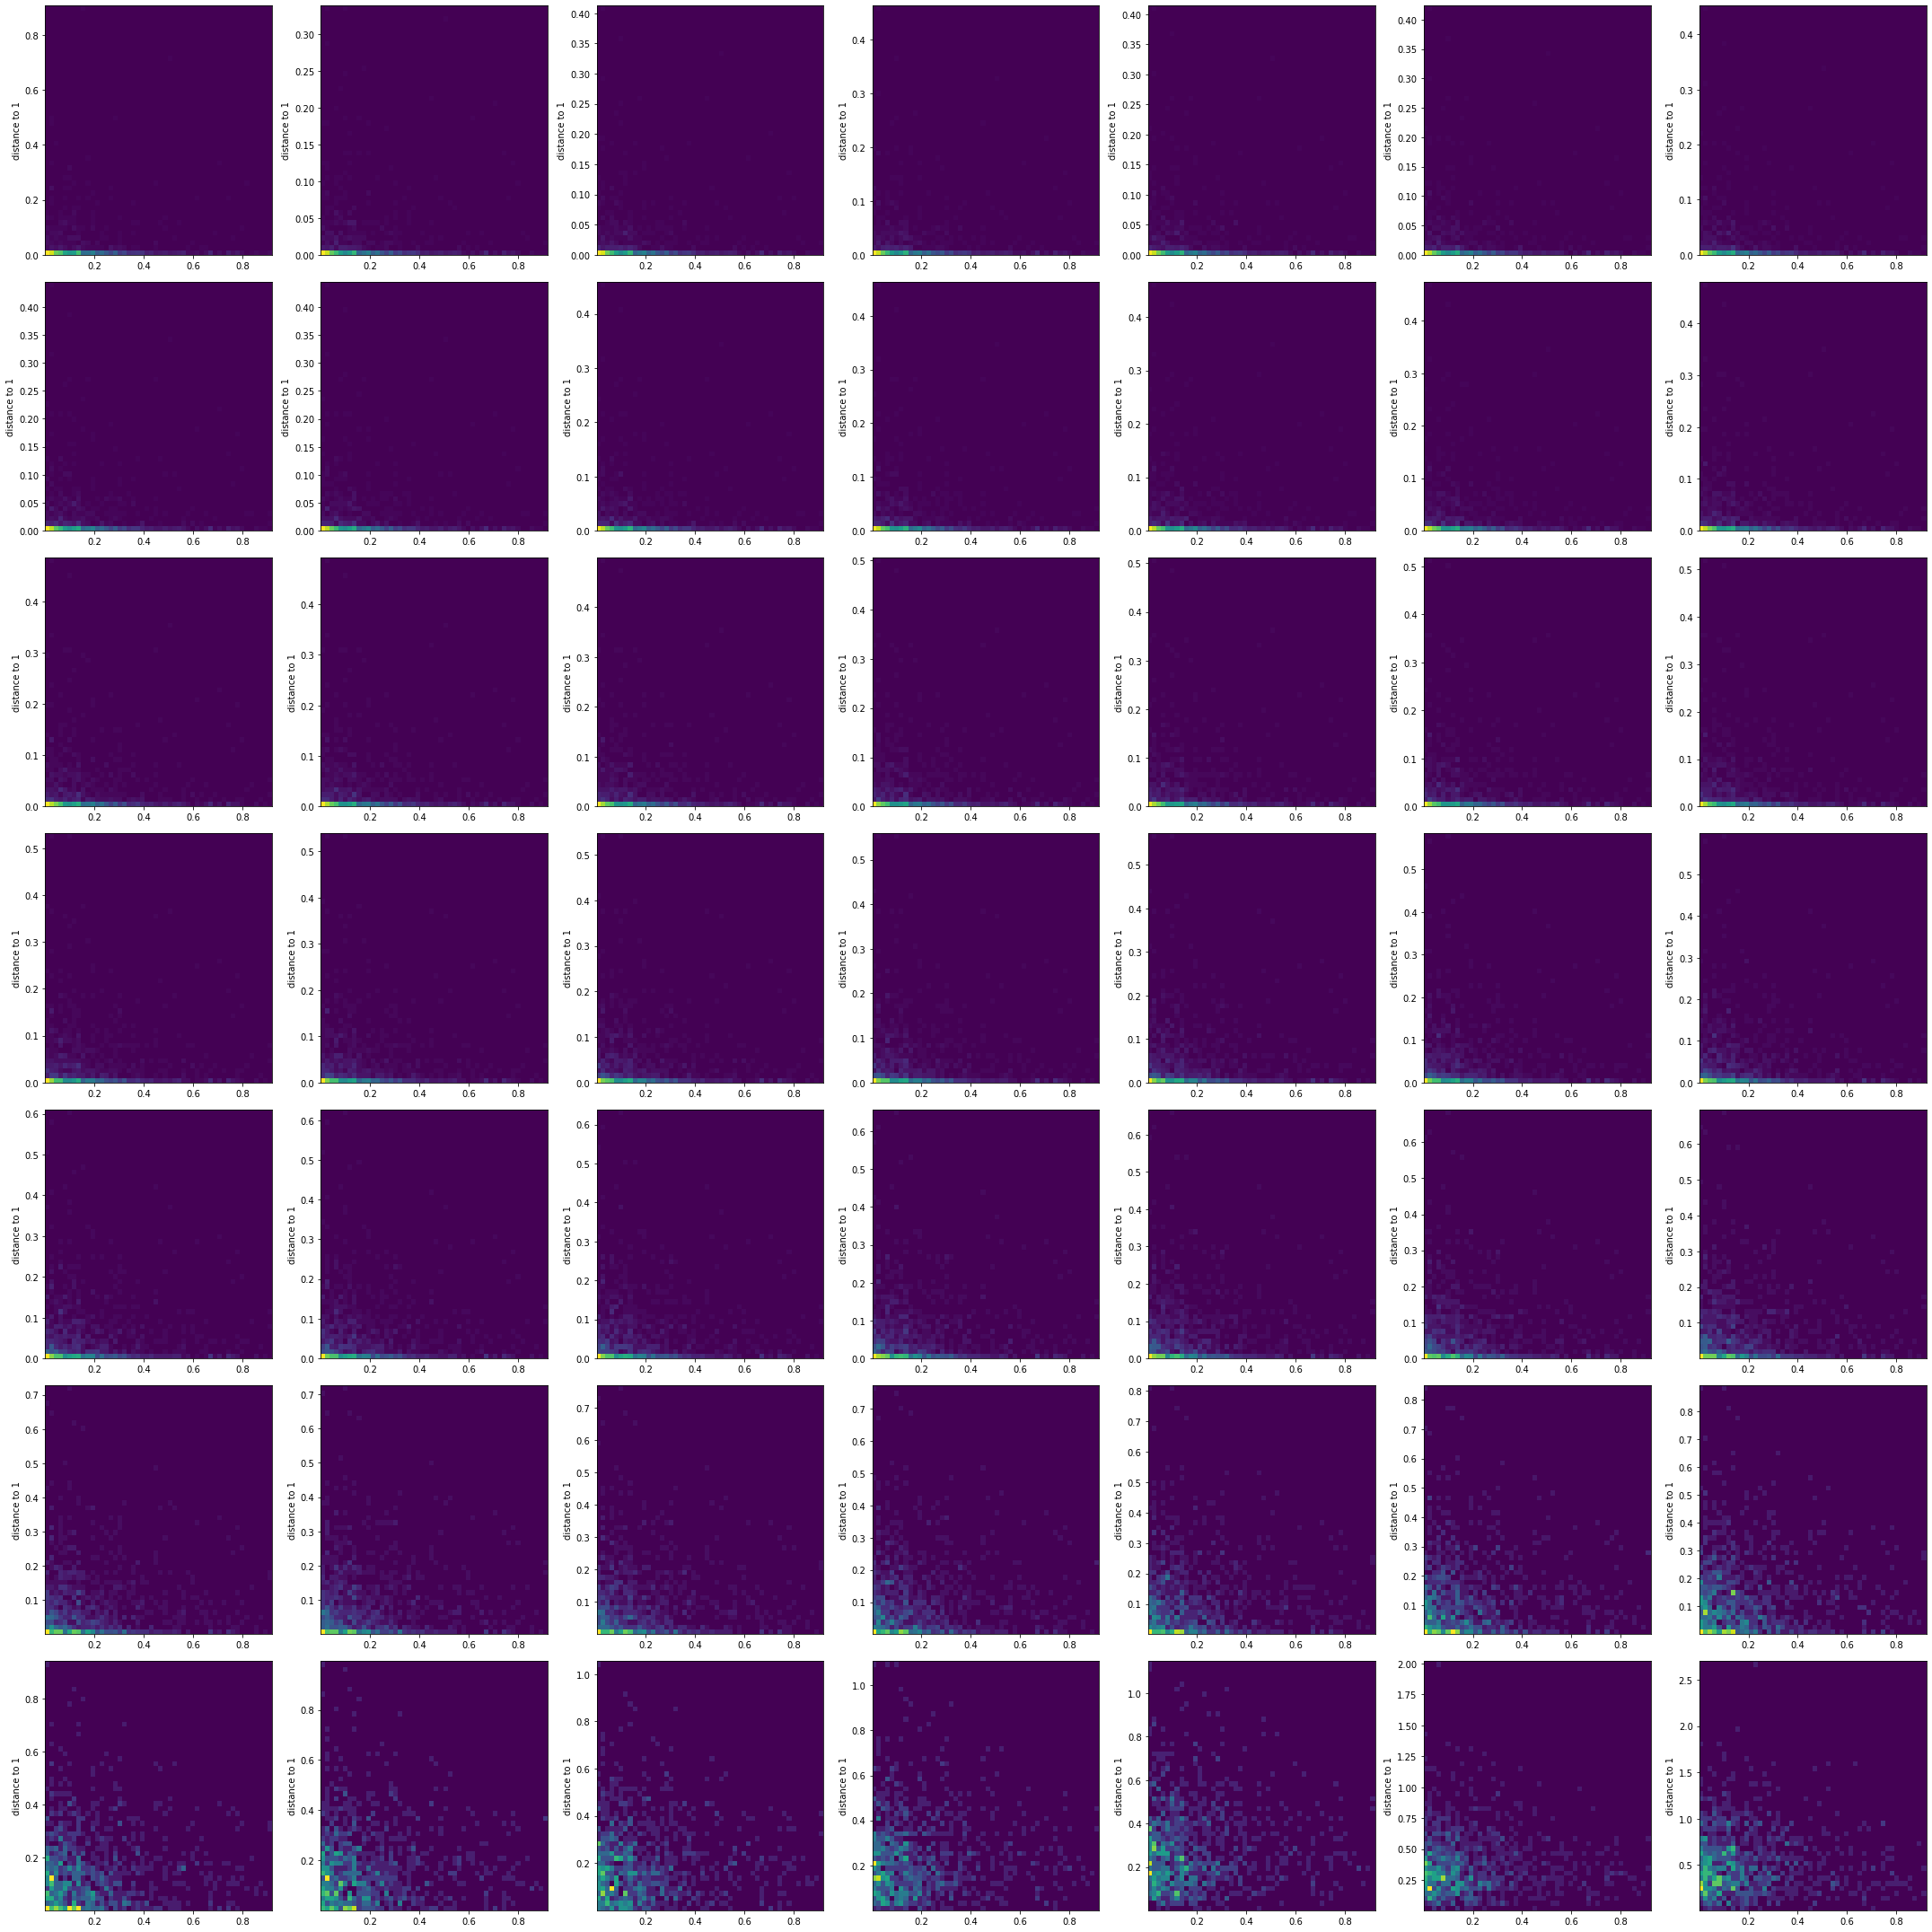

In [128]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    _=ax.hist2d(min_dis, -np.log(np.array(ps)[:,i]), bins=50)
    _=ax.set_ylabel(fr'\log(1/overlap)')
    _=ax.set_ylabel(fr'distance to 1')
_=fig.tight_layout()    
plt.show()

($y$ axis is $-\log(overlap)$, lower is better).

We get two eigenvalues $(\lambda_1,\lambda_2)$ per matrix. It seems that $\sqrt{(1-\lambda_1)^2 + (1-\lambda_2)^2}$ is uncorrerlated with the overlap. On the other hand, it seems that there might be some relation between 
$\min(|1-\lambda_1|,|1-\lambda_2|)$ and overlap. However, it's not clear that the accumulation is just from taking them minimum. It kind of seems like there's a relation, since there is still some accumulation when we only take the distance from the first eigenvalue.